# Application of linear response theory method to individual ensemble members (CESM)
Here, we apply the linear response theory method to individual ensemble members. This is done using the block bootstrapping methodology. We compare to the true value from the notebook true_freshwater_fluxes_longertimeseries_integration.ipynb and then apply significance criteria on the salinity trends to select only for members with high enough signal to noise ratio. This file is similar to individual_ensemble_members_CESM_integration.ipynb except is for future timeseries (2011 to 2055).

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

## Applying to all ensemble members
Above, we showed an example of applying linear response theory to one individual ensemble member by first producting an artificial ensemble using block bootstrapping. We now want to test on all 34 members of the ensemble

In [2]:
# The .py file that runs the above process that we outlined through all 34 members is called run_bootstrap_cesm_ensemble.py
#Let's load in the output from that file here that was pickled

import os
cwd = os.getcwd() #current working directory
cwd=cwd.replace("longer_time_series","")

#Area weighted
import pickle
with open(cwd+"/pickled_files/bootstrap_mean_3000_2011to2050_weighted_new", "rb") as fp:   #Unpickling
    trend_uncertainty_bootstrap_mean=pickle.load(fp)
with open(cwd+"/pickled_files/bootstrap_std_3000_2011to2050_weighted_new", "rb") as fp:   #Unpickling
    trend_uncertainty_bootstrap_std=pickle.load(fp)
    

#unpickle true fluxes from true_freshwater_fluxes.ipynb 
import pickle
with open(cwd+"/pickled_files/freshwater_fluxes_integration_mean_boot_2011to2055_new", "rb") as fp:   #Unpickling
    mean_boot=pickle.load(fp)
with open(cwd+"/pickled_files/freshwater_fluxes_integration_std_boot_2011to2055_new", "rb") as fp:   #Unpickling
    std_boot=pickle.load(fp)

Text(0.5, 0.92, 'Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member')

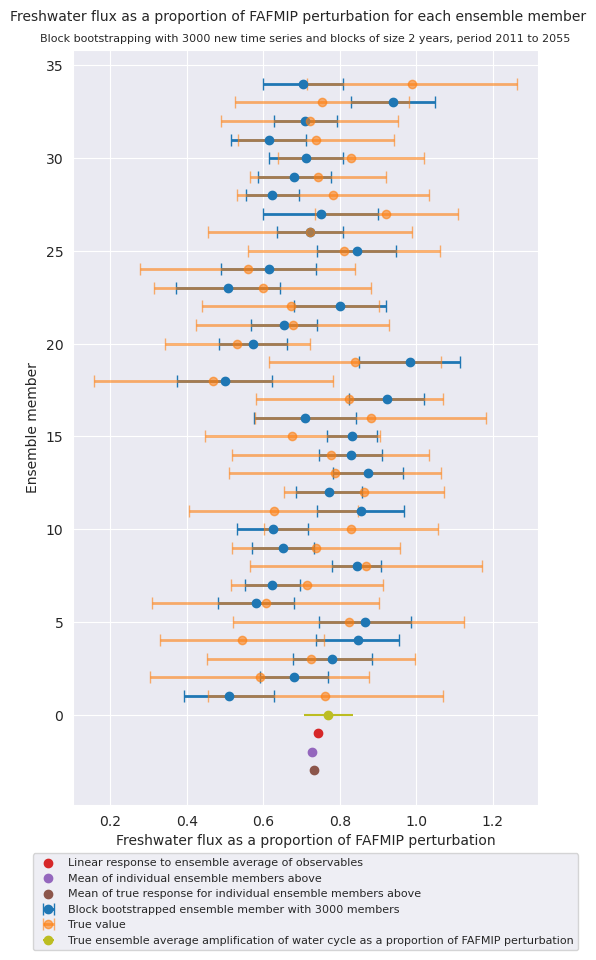

In [3]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(trend_uncertainty_bootstrap_mean, np.linspace(1,34,34),xerr=trend_uncertainty_bootstrap_std,fmt ='o',
        color='tab:blue',ms=6, capsize=4, elinewidth=2, label='Block bootstrapped ensemble member with 3000 members')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o', color='tab:orange',alpha=0.6,
        ms=6, elinewidth=2, capsize=4, label='True value')

ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(7.697617409610814e-01,0,xerr=0.06405399721172099, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.7424452150036277,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

ax.scatter(np.average(trend_uncertainty_bootstrap_mean,weights=trend_uncertainty_bootstrap_std),-2,color='tab:purple',label='Mean of individual ensemble members above')
ax.scatter(np.average(mean_boot,weights=std_boot),-3,color='tab:brown',label='Mean of true response for individual ensemble members above')

ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years, period 2011 to 2055',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)
#mpl.pyplot.savefig('future_indiv_ensemble_newstyle_23feb.png', dpi=500,bbox_inches='tight')

### Select for ensemble members which meet certain significance criteria
The method above works well for some members and not for others. If we were to look closer, we can see that members that are not capturing the response tend to have insignificant linear trends (compared to the scale of internal variability). One way to see this is choosing ensemble member 18 above in the individual example - here, the p value of the linear trend is insignificant for all regions.

We come up with sufficient (but not necessary) criteria for correctly capturing the true response. First we need to calculate pvalues. We calculate the p value from the confidence interval after bootstrapping (of the change in last 5 years compared to first 5 years). We could pretty equivalently use the p value of the original linear fit to the trend.

In [4]:
# We calculate the two forms of p value for the salt trends in the file  pvalue_salt_trends.py
import os
import pickle
cwd = os.getcwd() #current working directory
cwd=cwd.replace("longer_time_series","")

with open(cwd+"/pickled_files/pvalue_from_bootstrap_2011to2055", "rb") as fp:   #Unpickling the pvalues for each region for each ensemble member from block bootstrapping
    pvalue_bootstrap_store=pickle.load(fp)

In [5]:
## We first look at the mean of the pvalues in each of the regions across ensemble members
for j in range(0,6):
    print(pvalue_bootstrap_store[:,j].mean())
    
#We see that generally regions 2,6 are significant and regions 1,3,4,5 are not significant - in this case the signal is largely natural variability and not forced resposne

4.878385930323161e-03
3.135993731299779e-05
8.682982989760188e-06
0.010822532928564416
0.034536919047561385
2.865220498034491e-42


In [6]:
# After some playing around, one restriction that seems to guarantee finding the correct response is Let's try regions 2 and 6 have to have p value < 0.05
#regions 1,3,5 have to have p value <0.18. No restrictions for region 4 (doesn't seem to affect)

#Note that we can make these restrictions stricter too - can place a restriction on region 4, but don't need to.

#It is important that these are sufficient but not necessary conditions 

for i in range(0,34):    
    if pvalue_bootstrap_store[i,0]>0.18:
        trend_uncertainty_bootstrap_mean[i]=np.nan
        trend_uncertainty_bootstrap_std[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan
        
    if pvalue_bootstrap_store[i,1]>0.05:
        trend_uncertainty_bootstrap_mean[i]=np.nan
        trend_uncertainty_bootstrap_std[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

    if pvalue_bootstrap_store[i,2]>0.18: 
        trend_uncertainty_bootstrap_mean[i]=np.nan
        trend_uncertainty_bootstrap_std[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

#no restriction on fourth region

    if pvalue_bootstrap_store[i,4]>0.18:
        trend_uncertainty_bootstrap_mean[i]=np.nan
        trend_uncertainty_bootstrap_std[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

    if pvalue_bootstrap_store[i,5]>0.05: 
        trend_uncertainty_bootstrap_mean[i]=np.nan
        trend_uncertainty_bootstrap_std[i]=np.nan
        mean_boot[i]=np.nan
        std_boot[i]=np.nan

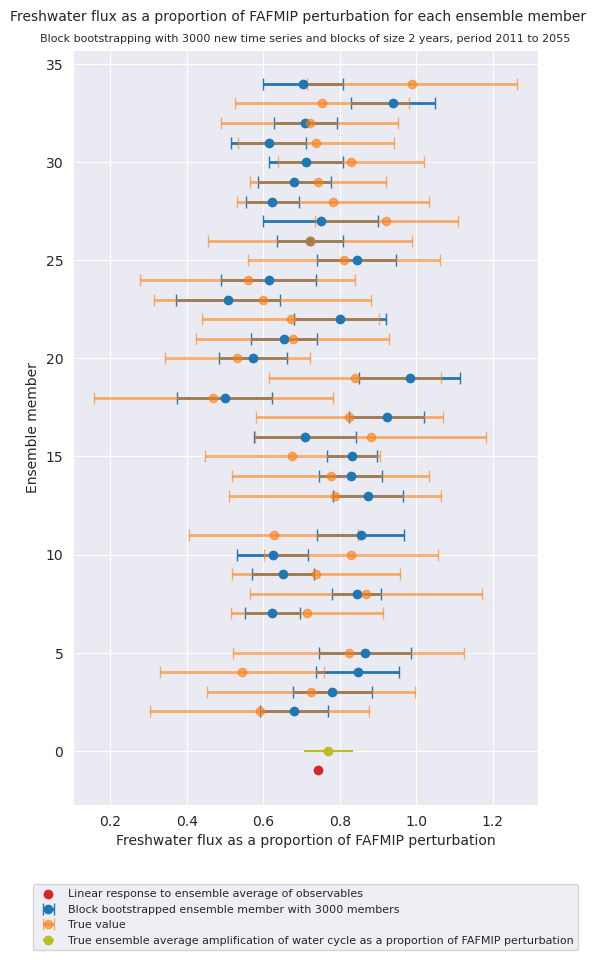

In [7]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax=plt.subplots(figsize=(6,10))
plt.errorbar(trend_uncertainty_bootstrap_mean, np.linspace(1,34,34),xerr=trend_uncertainty_bootstrap_std,fmt ='o',
        color='tab:blue',ms=6, elinewidth=2, capsize=4, label='Block bootstrapped ensemble member with 3000 members')
plt.errorbar(mean_boot, np.linspace(1,34,34),xerr=std_boot,fmt ='o', color='tab:orange',alpha=0.6,
        ms=6, elinewidth=2, capsize=4, label='True value')

ax.set_ylabel('Ensemble member')
ax.set_xlabel('Freshwater flux as a proportion of FAFMIP perturbation')
ax.errorbar(7.697617409610814e-01,0,xerr=0.06405399721172099, color='tab:olive',fmt ='o',
        ms=6,label='True ensemble average amplification of water cycle as a proportion of FAFMIP perturbation') #this value comes from true_freshwater_fluxes.ipynb

ax.scatter(0.7424452150036277,-1,color='tab:red',label='Linear response to ensemble average of observables') #this value comes from linear_response_CESM_ensemblemean.ipynb

ax.legend(loc='lower center',bbox_to_anchor=(0.5,-0.2),fontsize=8)
plt.title('Block bootstrapping with 3000 new time series and blocks of size 2 years, period 2011 to 2055',fontsize=8)
plt.suptitle('Freshwater flux as a proportion of FAFMIP perturbation for each ensemble member',fontsize=10, y=0.92)
mpl.pyplot.savefig('future_indiv_ensemble_newstyle_final_onlysig_integ.png', dpi=300,bbox_inches='tight')